In [9]:
import cv2
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd

%matplotlib inline

In [ ]:
import splitfolders
splitfolders.ratio('Knee X-ray Images', output="New_Dataset", seed=1345, ratio=(.8, 0.1,0.1))

# constants

In [4]:
IMG_SIZE = 224
DATA_DIR = "dataset"
TRAIN_DIR = 'train'
VAL_DIR = 'val'
TEST_DIR = 'test'

# histogram equalization

In [5]:
def equalize(img):
    img = img.astype('uint8')
    clahe = cv2.createCLAHE(tileGridSize=(8,8))
    img = clahe.apply(img)
    img = np.expand_dims(img, 2)  # This uses NumPy to add a new axis to the image img at position 2.(height, width, 1),
    return img

Convert the image to **uint8** format to ensure compatibility with image processing functions,
Set up the CLAHE algorithm with a grid size of
** 8x8 ** tiles, and
Apply CLAHE to enhance the contrast of the image.

In [14]:
def compare_equalized(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img2 = equalize(img).squeeze()
    img2 = np.hstack([img, img2])
    plt.imshow(img2, cmap='gray')
    plt.show()

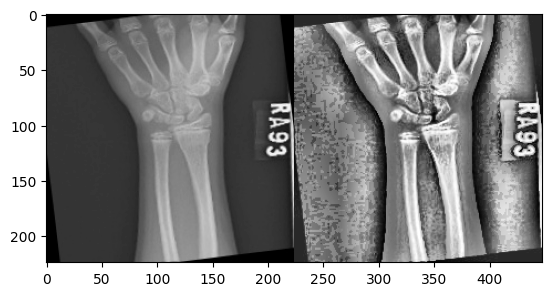

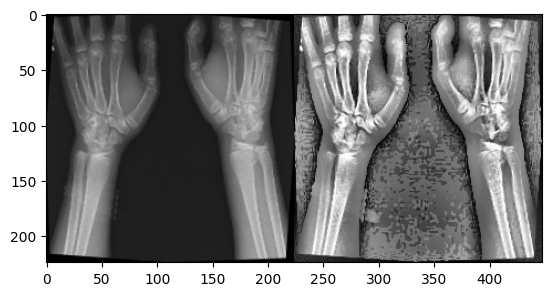

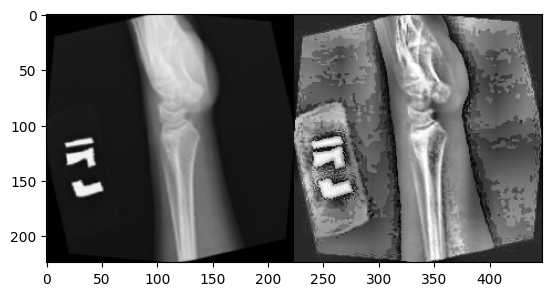

In [15]:
compare_equalized("dataset/val/fractured/1-rotated2-rotated1.jpg")
compare_equalized("dataset/val/fractured/97-rotated2-rotated2.jpg")
compare_equalized("dataset/val/fractured/99-rotated1-rotated2-rotated3.jpg")

# reading dataset (image data generators)

In [ ]:
train_gen = ImageDataGenerator(preprocessing_function=equalize).flow_from_directory(
    directory=os.path.join(DATA_DIR, TRAIN_DIR),
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=64,
)


val_gen = ImageDataGenerator(preprocessing_function=equalize).flow_from_directory(
    directory=os.path.join(DATA_DIR, VAL_DIR),
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=64,
)


test_gen = ImageDataGenerator(preprocessing_function=equalize).flow_from_directory(
    directory=os.path.join(DATA_DIR, TEST_DIR),
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=64,
)

Found 4097 images belonging to 2 classes.
Found 404 images belonging to 2 classes.
Found 399 images belonging to 2 classes.


# cnn model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 8)       80        
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 8)      32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 8)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 8)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      1

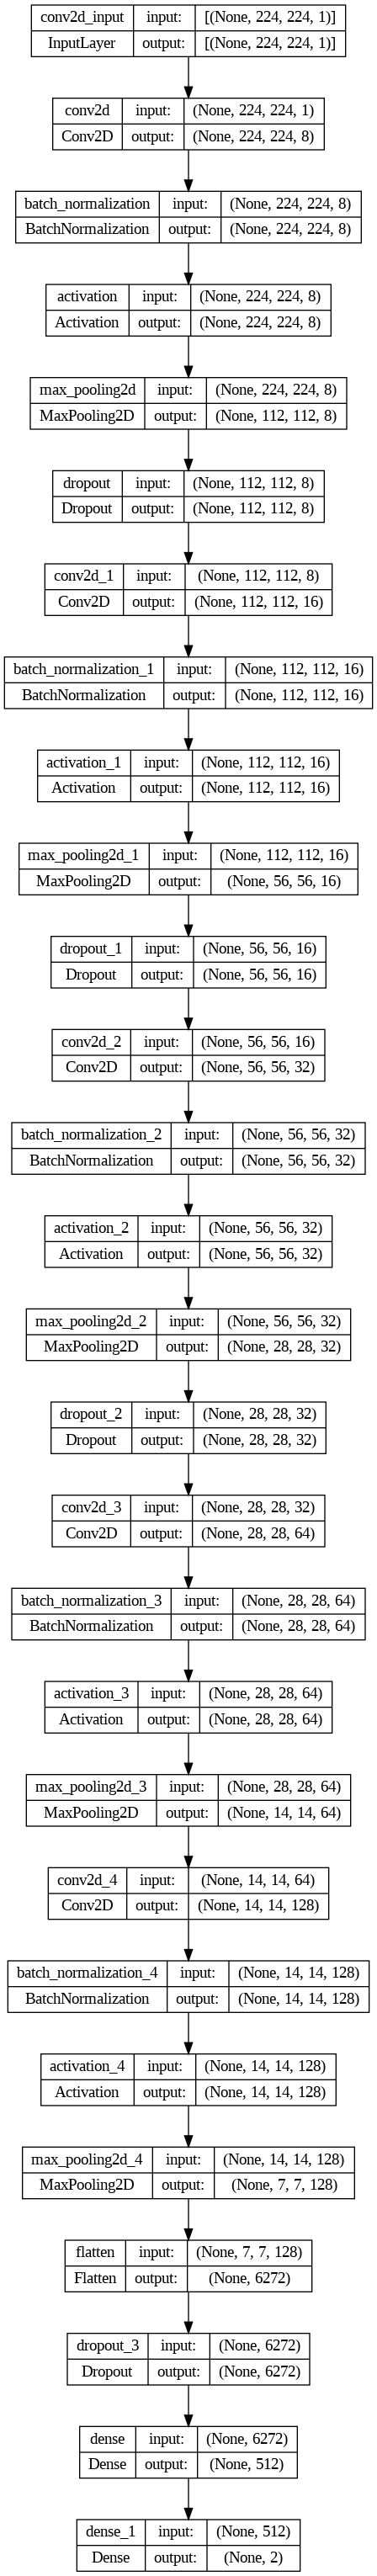

In [ ]:
from tensorflow import keras
model = Sequential()

#Feature extraction
model.add(Conv2D(8, kernel_size=3, padding='same',  input_shape=train_gen[0][0][0].shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(2, padding='same'))
model.add(Dropout(0.3))

model.add(Conv2D(16, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(2, padding='same'))
model.add(Dropout(0.3))

model.add(Conv2D(32, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(2, padding='same'))
model.add(Dropout(0.3))

model.add(Conv2D(64, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(2, padding='same'))

model.add(Conv2D(128, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(2, padding='same'))

#End of feature extraction

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Dense(train_gen[0][1].shape[1], activation='softmax'))

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',keras.metrics.Recall(),
                                                                        keras.metrics.SpecificityAtSensitivity(0.5) ])
model.summary()
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# training

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau, LearningRateScheduler
callbacks = [
            EarlyStopping(patience = 15, verbose=1),
            ReduceLROnPlateau(factor = 0.5, patience = 6, min_lr = 0.000001, verbose=1),
            ModelCheckpoint('model_bone.h5', monitor='val_loss', save_best_only=True,
            verbose=1)]

hist = model.fit(
    train_gen,
    validation_data=val_gen,
    shuffle=True,
    epochs=80,
    callbacks=callbacks,
)

Epoch 1/80
65/65 [==============================] - ETA: 0s - loss: 2.9065 - accuracy: 0.6268 - recall: 0.6268 - specificity_at_sensitivity: 0.7278
Epoch 1: val_loss improved from inf to 11.93607, saving model to model_bone.h5
65/65 [==============================] - 35s 311ms/step - loss: 2.9065 - accuracy: 0.6268 - recall: 0.6268 - specificity_at_sensitivity: 0.7278 - val_loss: 11.9361 - val_accuracy: 0.4158 - val_recall: 0.4158 - val_specificity_at_sensitivity: 0.0099 - lr: 5.0000e-04
Epoch 2/80
65/65 [==============================] - ETA: 0s - loss: 0.9240 - accuracy: 0.7110 - recall: 0.7110 - specificity_at_sensitivity: 0.8782
Epoch 2: val_loss improved from 11.93607 to 0.60104, saving model to model_bone.h5
65/65 [==============================] - 18s 280ms/step - loss: 0.9240 - accuracy: 0.7110 - recall: 0.7110 - specificity_at_sensitivity: 0.8782 - val_loss: 0.6010 - val_accuracy: 0.8144 - val_recall: 0.8144 - val_specificity_at_sensitivity: 0.9554 - lr: 5.0000e-04
Epoch 3/80


In [ ]:
#model.save("model.h5")

# training history (loss)

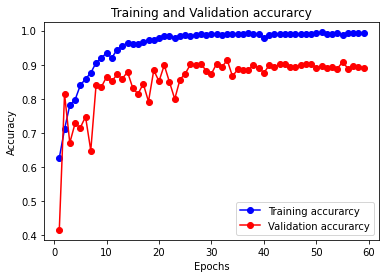

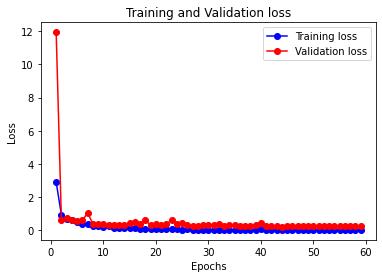

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b-o', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r-o', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b-o', label='Training loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# testing

In [7]:
from tensorflow import keras
model = keras.models.load_model('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
model.evaluate(test_gen)

7/7 [==============================] - 2s 160ms/step - loss: 0.0363 - accuracy: 0.9875 - recall: 0.9875 - specificity_at_sensitivity: 0.9975


[0.03630268946290016,
 0.9874686598777771,
 0.9874686598777771,
 0.9974937438964844]

# confusion matrix

In [ ]:
y_test = []
y_test_int = []
for i in tqdm(range(len(test_gen))):
    y_test += test_gen[i][1].tolist()
    y_test_int += test_gen[i][1].argmax(axis=1).tolist()
y_test = np.array(y_test)
y_test_int = np.array(y_test_int)

100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
y_pred_test = model.predict(test_gen, verbose=1)
y_pred_test_int = y_pred_test.argmax(axis=1)

7/7 [==============================] - 2s 311ms/step


               precision    recall  f1-score   support

    fractured       1.00      0.97      0.99       199
not fractured       0.98      1.00      0.99       200

     accuracy                           0.99       399
    macro avg       0.99      0.99      0.99       399
 weighted avg       0.99      0.99      0.99       399



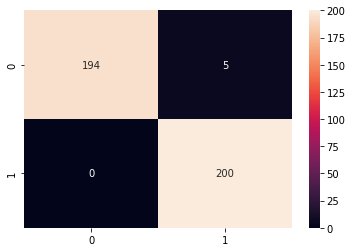

In [ ]:
import seaborn as sn
from sklearn.metrics import classification_report
cm = confusion_matrix(y_test_int, y_pred_test_int)
sn.heatmap(cm,annot=True,fmt="d")

target_names = ['fractured', 'not fractured']
print(classification_report(y_test_int, y_pred_test_int, target_names=target_names,digits=4))

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test_int, y_pred_test_int))

0.9874686716791979


# roc auc

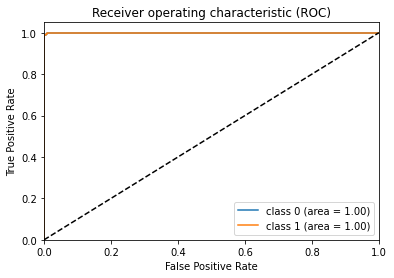

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='class {} (area = {:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [21]:
# need to check specific image  from the test folder using the loaded model

import cv2
import numpy as np

def predict_single_image(image_path, model):

  img = cv2.imread(image_path)
    # Check if the image was loaded correctly
  if img is None:
    print(f"Error: Could not load image at {image_path}")
    return None, None

  img = cv2.resize(img, (224, 224))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = equalize(img)
  img = np.expand_dims(img, axis=0)  # Add batch dimension
  prediction = model.predict(img)
  predicted_class = np.argmax(prediction)
  probability = prediction[0][predicted_class]

  return predicted_class, probability

# Example usage:
image_path = "dataset/test/fractured/1-rotated1-rotated2-rotated1.jpg"  # Replace with your image path
predicted_class, probability = predict_single_image(image_path, model)

print(f"Predicted class: {predicted_class}")
print(f"Probability: {probability}")

# You can map the predicted class to your actual class labels (e.g., 'fractured', 'not fractured')
class_labels = ['fractured', 'not fractured']
print(f"Predicted label: {class_labels[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted class: 0
Probability: 1.0
Predicted label: fractured


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


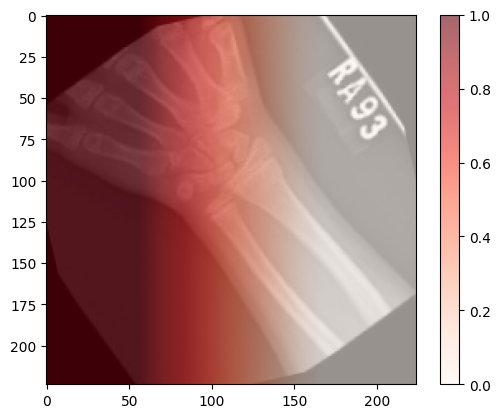

In [36]:
image_path = "dataset/test/fractured/1-rotated2-rotated3-rotated1 - Copy.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

input_image = cv2.resize(image, (224, 224))
input_image = np.stack((input_image,), axis=-1) # to (height, width, 1).
input_image = equalize(input_image)
input_image = input_image / 255.0
input_image = np.expand_dims(input_image, axis=0) # to (1,height, width, 1).

predictions = model.predict(input_image)
heatmap = cv2.resize(predictions, (image.shape[1], image.shape[0]))
plt.imshow(image, cmap='gray')
plt.imshow(heatmap, cmap='Reds', alpha=0.6)
plt.colorbar()
plt.show()